In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
from pyaspeller import YandexSpeller
import spacy
from spacy.lang.ru import Russian
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm 
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords

from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
speller = YandexSpeller()
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gennadiy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
df = pd.read_csv('train_dataset_train.csv')
df.head()

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,Аварийные деревья,Администрация города Курска,3
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,Нескошенная сорная растительность в местах общ...,Комитет дорожного хозяйства города Курска,3
4,1797,<p style=`text-align:justify;`><span style=`ba...,Аварийные деревья,Комитет городского хозяйства города Курска,3


In [17]:
df.rename(columns={'Текст Сообщения': 'message', 'Тематика':'themes', 'Ответственное лицо': 'resp_p', 'Категория':'category'}, inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2000 non-null   int64 
 1   message   2000 non-null   object
 2   themes    2000 non-null   object
 3   resp_p    2000 non-null   object
 4   category  2000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 78.2+ KB


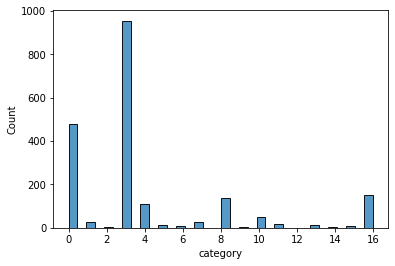

In [19]:
sns.histplot(data=df.category);

Классы сильно несбалансировано, далее мы увидим, что у 12-го класса вообще всего один элемент

In [20]:
df.drop(columns=['id', 'themes', 'resp_p'], inplace=True)

In [186]:
# df["resp_p"] = pd.Categorical(df["resp_p"])
# df["resp_p"].astype('category').cat.codes
# df["resp_p"] = df["resp_p"].cat.codes

# df["themes"] = pd.Categorical(df["themes"])
# df["themes"].astype('category').cat.codes
# df["themes"] = df["themes"].cat.codes

### Делаем небольшую стандартизацию текста и проверяем орфографические ошибки

In [21]:
df['token'] = 0 
df['token'] = df['token'].astype(object)

In [30]:
sw = stopwords.words("russian")

# extend specific stopwords 
sw.extend(('здравствовать', 'ваш', 'др', 'здравствуйте', 'тд', 'тч', 'тп', 'из-за', 'как-то', 'так-то', 'тк', 'это', 'наш', 'свой', 'либо', 'очень', 'какой-то', 'из-под', 'что-то', 'кто-то'))

# dict for replace words
d_replace = {
    "ул": "улица", 
    "км": "километр", 
    "кв": "квартира"
    }

def standartize_text(sentence):

    doc = Doc(sentence)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)
    
    for span in doc.spans:
        span.normalize(morph_vocab)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    # remove names
    for span in doc.spans:
        if span.type == PER:
            span.extract_fact(names_extractor)

    names = [_.text for _ in doc.spans if _.type == PER and _.fact]
    
    if names:
        for name in names: 
            sentence = sentence.replace(name, ' ')


    # use re to formate sentences
    sentence = re.sub(r"[^а-яА-ЯёЁ@\'\-\"\ \_\n]", " ", sentence)
    sentence = re.sub(r'\s+', ' ', sentence)

    doc = Doc(sentence)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    # check speller words
    changes = {change['word']: change['s'][0] for change in speller.spell(sentence)}
    for word, suggestion in changes.items():
        sentence = sentence.replace(word, suggestion)


    # remove stopwords and words with one sign
    sentence = [token.lemma for token in doc.tokens if token.lemma not in sw and len(token.lemma) != 1]
    word_del = []

    # remove phrase `добрый(ое) утро/вечер/день`
    for index, word in enumerate(sentence):
        if index != len(sentence) - 1:
            next_word = sentence[index + 1]
            if word.lower() in ('добрый', 'доброе') and next_word.lower() in ('вечер', 'день', 'утро'):
                word_del.extend((word, next_word))
            if word[0] in ('-', '!') or word[-1] in ('-', '!'):
                word_del.append(word) 

            # replace words
            if word.lower() in d_replace:
                sentence[sentence.index(word)] = d_replace[word.lower()]

    if word_del:
        for word_d in word_del: sentence.remove(word_d)


    return ' '.join(sentence)


In [31]:
# standartize sentences
for row in tqdm(df.itertuples(), total=df.shape[0]):

    df.at[row[0], 'token'] = standartize_text(row[1])

  0%|          | 0/2000 [00:00<?, ?it/s]

In [32]:
df.to_csv('after_processing.csv', index=False)

In [33]:
df = pd.read_csv('after_processing.csv')
test_df = pd.read_csv('test_dataset_test.csv')

In [34]:
words = 0
for row in df.itertuples():
    words += len(row[3])

num_of_w_per_sample = words / df.shape[0]
print('Number of words per sample: %.2f\nRatio: %.2f' %(num_of_w_per_sample, df.shape[0] / num_of_w_per_sample))


Number of words per sample: 267.64
Ratio: 7.47


In [38]:
# category with 5 objects
category = df.category.value_counts().to_dict()
category_with_few_ob = [k for k, v in category.items() if v <= 5]
category_with_few_ob 

[9, 14, 2, 12]

Classes are disbalanced

In [39]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical

all_words = [word for token in df["token"] for word in token.split()]
sentence_lengths = [len(token.split()) for token in df["token"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

65340 words total, with a vocabulary size of 8416
Max sentence length is 805


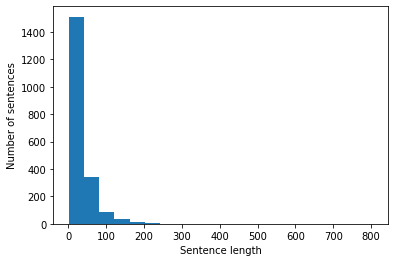

In [52]:
fig = plt.figure(figsize=(6, 4)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths, bins=20)
plt.show();

In [ ]:
test_df.drop(columns=['Тематика', 'Ответственное лицо'], inplace=True)

In [61]:
test_df['token'] = 0
test_df['token'] = test_df['token'].astype('O')
for row in tqdm(test_df.itertuples(), total=test_df.shape[0]):

    test_df.at[row[0], 'token'] = standartize_text(row[2])

  0%|          | 0/1000 [00:00<?, ?it/s]

***

In [81]:
# manually generate objects for 12 category
df = df.append({'token': 'свидетельство получение затруднено', 'category': 12}, ignore_index=True)
df = df.append({'token': 'подтверждение получение невозможно', 'category': 12}, ignore_index=True)

/tmp/ipykernel_41461/1268235252.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'token': 'свидетельство получение затруднено', 'category': 12}, ignore_index=True)


In [82]:
# generate objects 
X_train = df.token
y_train = df.category
X_test = test_df.token
from imblearn.over_sampling import SMOTE
os = SMOTE(k_neighbors=2, random_state=0)
vectorizer = CountVectorizer()
vectorizer.fit(X_train.values.ravel())
X_train=vectorizer.transform(X_train.values.ravel())
X_test=vectorizer.transform(X_test.values.ravel())
X_train=X_train.toarray()
X_test=X_test.toarray()
x_train = pd.DataFrame(X_train)
X_resample, y_resampled = os.fit_resample(X_train, y_train)


In [ ]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95, stop_words=sw)
tfidf_vectorizer.fit_transform(X_resample)

train_feature_set=tfidf_vectorizer.transform(X_resample)
test_feature_set=tfidf_vectorizer.transform(X_test)

In [65]:
# Загрузка логистической регрессии
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.70)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(penalty='l2' ,n_jobs=1, C=1e5)),
               ])

logreg.fit(X_train, y_train) 

/home/gennadiy/anaconda3/envs/class_appeal/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.7, min_df=2, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [63]:
predict = logreg.predict(test_df['token'])

In [64]:
res = pd.read_csv('sample_solution.csv')
res['Категория'] = predict
res.to_csv('results_logreg.csv', index=False)

___

In [10]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(2, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='elasticnet',alpha=1e-3, random_state=0, max_iter=20, tol=None)),
               ])

In [11]:
sgd.fit(X_train, y_train)  # Обучение модели
y_pred = sgd.predict(X_test)

In [9]:
res = pd.read_csv('sample_solution.csv')
res['Категория'] = y_pred
res.to_csv('results_sgd.csv', index=False)

In [26]:
df.token = df.token.apply(lambda s: s.replace('который ', ''))

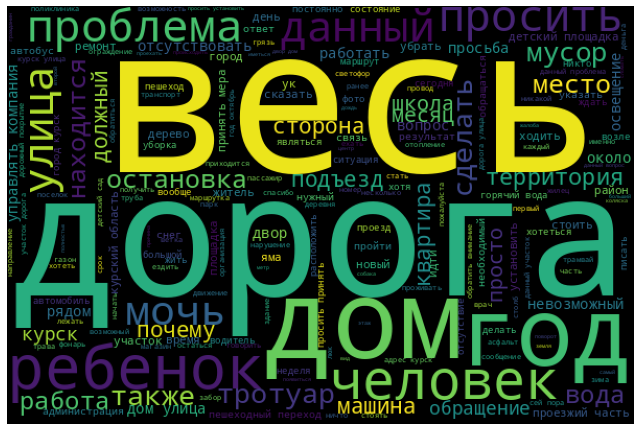

In [28]:
from wordcloud import WordCloud

# Generate a word cloud image for positive reviews
pos_str=''
for string in df['token']:
    if(string not in sw):
        pos_str=pos_str+string+' '
polarity_pos_wordcloud = WordCloud(width=600, height=400).generate(pos_str)
plt.figure( figsize=(9,9))
plt.imshow(polarity_pos_wordcloud)
plt.axis("off")
plt.tight_layout()
plt.show()

In [38]:
df = pd.concat([df, test_df], ignore_index=True)

In [40]:
df.drop(columns=['id', 'themes', 'resp_p'], inplace=True)

In [49]:
df.loc[2000:]

,message,category,token
2000,Здравствуйте На улице Мира было заменено нару...,NaN,улица мир заменить наружный освещение именно з...
2001,Уже вторую неделю не горит уличное освещение,NaN,второй неделя гореть уличный освещение
2002,Не работает освещение во дворе дома а по Энерг...,NaN,работать освещение двор дом энергетик световой...
2003,После покоса сорной растительности на газоне м...,NaN,покос сорный растительность газон тротуар прое...
2004,Прошу принять меры к водителю маршрута пос Се...,NaN,просить принять мера водитель маршрут пос севе...
...,...,...,...
2995,Добрый день Я и моя семья жители пос Волокно м...,NaN,семья житель пос волокно просыпаться засыпать ...
2996,На Лазарева г Щигры ветка тополя скоро выбьет ...,NaN,лазарев щигры ветка тополь скоро выбить стекло...
2997,Перед входом Комитет образования Курска ямы на...,NaN,вход комитет образование курск яма дорога
2998,Доброго времени суток У меня на пол года был ...,NaN,добрый время сутки пол год медотвод вакцинация...


In [50]:
df.token = df.token.apply(lambda s: s.replace('который ', ''))

In [51]:
vect =TfidfVectorizer(stop_words=sw) # to play with. min_df,max_df,max_features etc...
X=vect.fit_transform(df['token'])


In [55]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder

dtm_df=pd.DataFrame(X.toarray(), columns=vect.get_feature_names()) 

le=LabelEncoder()
dtm_df['token']=le.fit_transform(df['token'])

/home/gennadiy/anaconda3/envs/class_appeal/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [61]:
x_train = dtm_df.loc[:1999].drop('token', axis=1)
y_train = df.loc[:1999].category
clf_lr=LogisticRegression(C=150)
clf_lr.fit(x_train,y_train)

/home/gennadiy/anaconda3/envs/class_appeal/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=150)

In [63]:
pred=clf_lr.predict(dtm_df.loc[2000:].drop('token', axis=1))

In [77]:
res = pd.read_csv('sample_solution.csv')
res['Категория'] = a
res.to_csv('results_logreg_2.csv', index=False)

/home/gennadiy/anaconda3/envs/class_appeal/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


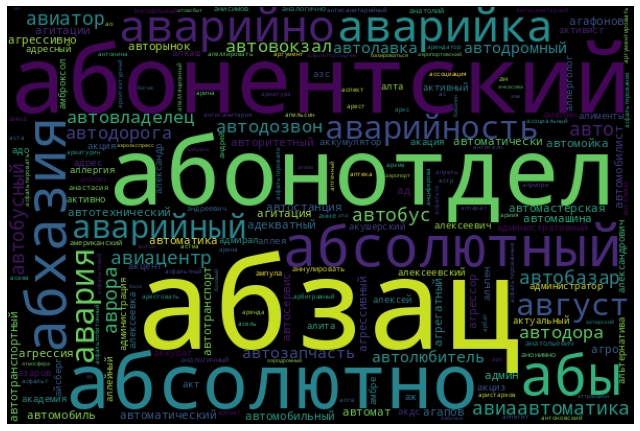

In [33]:
list=vect.get_feature_names()
features=""
for feature in list:
    features=features+feature+" "
wordcloud = WordCloud(width=600, height=400).generate(features)
plt.figure( figsize=(9,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout()
plt.show()

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [84]:
l = 0
for i in df.token:
    if len(i.split()) > l:
        l = len(i.split())
l

1046

In [85]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина текста
max_text_len = 1050
# Количество классов 
nb_classes = 17

tokenizer = Tokenizer(num_words=num_words, filters='!"“”‚#$%&amp;()*+,-—./:;&lt;=>?@[\\]^_`{|}~\t\n\xa0')
tokenizer.fit_on_texts(df['token'])
sequences = tokenizer.texts_to_sequences(df.loc[:1999]['token'])
X_train = pad_sequences(sequences, maxlen=max_text_len)
y = df.loc[:1999].category
y_train = utils.to_categorical(y, 17)
y_train[:5][0]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

In [100]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_text_len)) # ?????
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(17, activation='softmax'))

In [101]:
model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
              

In [102]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      save_best_only=True,
                                      verbose=1)

In [103]:
history_cnn = model_cnn.fit(X_train, 
                            y_train, 
                            epochs=10,
                            batch_size=32,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/10


2022-07-07 11:26:46.127934: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33472000 exceeds 10% of free system memory.
2022-07-07 11:26:47.445029: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33472000 exceeds 10% of free system memory.


 1/63 [..............................] - ETA: 7:16 - loss: 2.8433 - accuracy: 0.0625

2022-07-07 11:26:50.247018: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33472000 exceeds 10% of free system memory.
2022-07-07 11:26:50.367949: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33472000 exceeds 10% of free system memory.


 2/63 [..............................] - ETA: 33s - loss: 2.8215 - accuracy: 0.1719 

2022-07-07 11:26:50.858455: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33472000 exceeds 10% of free system memory.


63/63 [==============================] - 33s 426ms/step - loss: 1.8957 - accuracy: 0.4655
Epoch 2/10
63/63 [==============================] - 24s 377ms/step - loss: 1.3880 - accuracy: 0.5645
Epoch 3/10
63/63 [==============================] - 23s 366ms/step - loss: 1.0134 - accuracy: 0.6800
Epoch 4/10
63/63 [==============================] - 21s 338ms/step - loss: 0.6787 - accuracy: 0.8265
Epoch 5/10
63/63 [==============================] - 22s 351ms/step - loss: 0.4156 - accuracy: 0.8870
Epoch 6/10
63/63 [==============================] - 24s 380ms/step - loss: 0.2802 - accuracy: 0.9095
Epoch 7/10
63/63 [==============================] - 22s 346ms/step - loss: 0.2066 - accuracy: 0.9470
Epoch 8/10
63/63 [==============================] - 21s 338ms/step - loss: 0.1562 - accuracy: 0.9630
Epoch 9/10
63/63 [==============================] - 22s 343ms/step - loss: 0.1127 - accuracy: 0.9710
Epoch 10/10
63/63 [==============================] - 22s 355ms/step - loss: 0.0866 - accuracy: 0.9795


In [106]:
sequences = tokenizer.texts_to_sequences(df.loc[2000:]['token'])
X_te = pad_sequences(sequences, maxlen=max_text_len)
prediction = model_cnn.predict(X_te)
predict_class = np.argmax(prediction, axis=1)
predict_class = predict_class.tolist()
predict_class

32/32 [==============================] - 5s 115ms/step


[3,
 3,
 3,
 3,
 8,
 8,
 3,
 3,
 0,
 4,
 10,
 3,
 3,
 3,
 16,
 0,
 8,
 3,
 3,
 0,
 0,
 0,
 16,
 3,
 3,
 3,
 3,
 10,
 3,
 16,
 10,
 0,
 3,
 8,
 3,
 0,
 4,
 0,
 3,
 3,
 0,
 3,
 1,
 11,
 3,
 11,
 4,
 0,
 3,
 0,
 0,
 8,
 3,
 3,
 0,
 3,
 11,
 1,
 16,
 0,
 3,
 11,
 3,
 1,
 3,
 3,
 3,
 16,
 8,
 3,
 0,
 16,
 3,
 3,
 3,
 0,
 3,
 0,
 16,
 3,
 3,
 3,
 3,
 4,
 3,
 0,
 10,
 11,
 0,
 16,
 3,
 11,
 0,
 4,
 3,
 3,
 0,
 3,
 3,
 16,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 16,
 3,
 3,
 0,
 0,
 3,
 16,
 0,
 8,
 6,
 3,
 3,
 3,
 13,
 0,
 8,
 3,
 11,
 0,
 0,
 3,
 0,
 8,
 10,
 16,
 4,
 3,
 3,
 11,
 3,
 0,
 4,
 0,
 8,
 4,
 7,
 0,
 0,
 0,
 3,
 3,
 0,
 3,
 8,
 3,
 0,
 0,
 3,
 3,
 0,
 3,
 0,
 0,
 3,
 3,
 3,
 10,
 3,
 0,
 3,
 0,
 11,
 3,
 3,
 3,
 13,
 3,
 3,
 3,
 8,
 8,
 3,
 0,
 3,
 3,
 0,
 3,
 8,
 3,
 3,
 3,
 3,
 3,
 11,
 8,
 3,
 3,
 16,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 6,
 3,
 1,
 8,
 0,
 16,
 3,
 8,
 8,
 1,
 3,
 4,
 16,
 3,
 0,
 0,
 8,
 16,
 0,
 3,
 3,
 3,
 0,
 16,
 3,
 3,
 3,
 3,
 0,
 16,
 3,
 3,
 0,
 16,
 3,
 10,
 8,
 1

In [ ]:
res = pd.read_csv('sample_solution.csv')
res['Категория'] = predict_class
res.to_csv('results_keras_2.csv', index=False)